In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from merf.merf import MERF
import pickle
import shap
from sklearn.inspection import permutation_importance, partial_dependence
from py_modules import * # imports all custom functions

In [2]:
df= pd.read_csv('datasets/dataset_before_splitting.csv')

In [3]:
# Call the split_and_save_data function
results = split_and_save_data(df, 'PV1MATH', 'schoolID')

# Retrieve the outputs from the results dictionary
groups = results["groups"]
train_idx = results["train_idx"]
test_idx = results["test_idx"]
gss = results["gss"]
clusters_train = results["clusters_train"]  # Retrieve clusters for train set
clusters_test = results["clusters_test"]    # Retrieve clusters for test set

# Load the CSVs as before
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv', header=None).squeeze()  # Ensure target is loaded as a Series
y_test = pd.read_csv('y_test.csv', header=None).squeeze()

# Verify that clusters and datasets align
assert len(clusters_train) == len(X_train), "Mismatch between clusters_train and X_train"
assert len(clusters_test) == len(X_test), "Mismatch between clusters_test and X_test"

In [4]:
# grouping columns based on preprocessing method:
columns_to_transform = ['FAMSUP', 'STUBEHA', 'STAFFSHORT'] 
one_hot_cols = ['external_evaluation','Gender', 'additional_math_classes', 'PROGN'] 
one_hot_cols_merf = ['external_evaluation','Gender', 'additional_math_classes'] 
ohe_most_fr = ['LANGN', 'REPEAT', 'SCHLTYPE', 'IMMIG'] # these will have strategy = most_frequent since they have a small share of missing values
ordinal_columns = ['CLSIZE','math_grouping', 'degree_of_competition', 'municipality_size', 'EDUSHORT_binned']
columns_to_scale_and_transform = ['PROPSUPP', 'SCHSIZE', 'RATCMP1', 'BULLIED']
only_to_impute = ['ESCS', 'INSTLEAD', 'TEACHBEHA', 'DIGPREP', 'STRESAGR', 'EMOCOAGR', 'ANXMAT', 'COOPAGR', 'PERSEVAGR', 'BELONG']
dummy_cols = ['SCSUPRTED', 'PROATCE', 'PROBSCRI', 'track_student_attendance'] # columns to be transfomermed based on NAs
transformed_cols = columns_to_transform + columns_to_scale_and_transform

In [5]:
all_cols = columns_to_transform + ordinal_columns + one_hot_cols + columns_to_scale_and_transform  + dummy_cols + only_to_impute + ohe_most_fr 
print([col for col in  X_train.columns if col not in all_cols])  # these columns are already preprocessed and don't need further transformation

['SCHAUTO_ORDINAL']


In [6]:
# Preprocess for LASSO
X_train_prep_lasso, X_test_prep_lasso = preprocess_data(
    train=X_train,
    test=X_test,
    columns_to_transform=columns_to_transform,
    columns_to_scale_and_transform=columns_to_scale_and_transform,
    only_to_impute=only_to_impute,
    one_hot_cols_fr=ohe_most_fr,
    one_hot_cols=one_hot_cols,
    ordinal_columns=ordinal_columns,
    dummy_cols=dummy_cols,
    dropping_category='first'
)

# Preprocess for RF
X_train_prep_rf, X_test_prep_rf = preprocess_data(
    train=X_train,
    test=X_test,
    columns_to_transform=columns_to_transform,
    columns_to_scale_and_transform=columns_to_scale_and_transform,
    only_to_impute=only_to_impute,
    one_hot_cols_fr=ohe_most_fr,
    one_hot_cols=one_hot_cols,
    ordinal_columns=ordinal_columns,
    dummy_cols=dummy_cols,
    dropping_category=None
)

# Preprocess for MERF

X_train_prep_merf, X_test_prep_merf = preprocess_data(
    train=X_train,
    test=X_test,
    columns_to_transform=columns_to_transform,
    columns_to_scale_and_transform=columns_to_scale_and_transform,
    only_to_impute=only_to_impute,
    one_hot_cols_fr=ohe_most_fr,
    one_hot_cols=one_hot_cols_merf,  # Excludes 'PROGN'
    ordinal_columns=ordinal_columns,
    dummy_cols=dummy_cols,
    dropping_category=None
)

In [7]:
X_train_prep_lasso.to_csv("X_train_prep_lasso.csv", index=False)
X_test_prep_lasso.to_csv("X_test_prep_lasso.csv", index=False)

X_train_prep_rf.to_csv("X_train_prep_rf.csv", index=False)
X_test_prep_rf.to_csv("X_test_prep_rf.csv", index=False)

X_train_prep_merf.to_csv("X_train_prep_merf.csv", index=False)
X_test_prep_merf.to_csv("X_test_prep_merf.csv", index=False)

In [7]:
# use this if you need to reload
X_train_prep_lasso = pd.read_csv("X_train_prep_lasso.csv")
X_test_prep_lasso = pd.read_csv("X_test_prep_lasso.csv")
X_train_prep_rf = pd.read_csv("X_train_prep_rf.csv")
X_test_prep_rf = pd.read_csv("X_test_prep_rf.csv")
X_train_prep_merf = pd.read_csv("X_train_prep_merf.csv")
X_test_prep_merf = pd.read_csv("X_test_prep_merf.csv")

In [8]:
results_lasso = nested_cross_validation(
    objective_function=objective_lasso,  
    X=X_train_prep_lasso, 
    y=y_train, 
    groups=groups.iloc[train_idx], # we need only groups from training
    model_class=Lasso,  
    n_trials=100,
    outer_splits=5,
    metric="rmse"
)

[I 2024-12-21 17:21:52,269] A new study created in memory with name: no-name-ea7798cb-9738-4288-a654-e2bc9492d188


[I 2024-12-21 17:21:52,478] Trial 0 finished with values: [75.87154161877561, 60.87190612764, 0.2333485527183159] and parameters: {'alpha': 1.677619859188859}.
[I 2024-12-21 17:21:52,563] Trial 1 finished with values: [78.904353509748, 63.382654501406776, 0.1703224237371154] and parameters: {'alpha': 4.9066372211860845}.
[I 2024-12-21 17:21:52,620] Trial 2 finished with values: [80.26971818907857, 64.54342131779065, 0.14138310818868174] and parameters: {'alpha': 7.800384832131743}.
[I 2024-12-21 17:21:52,679] Trial 3 finished with values: [79.38273768499832, 63.78624264896293, 0.16015373166260602] and parameters: {'alpha': 5.442295655333181}.
[I 2024-12-21 17:21:52,741] Trial 4 finished with values: [80.98640863532228, 65.18964036532944, 0.12599857730370556] and parameters: {'alpha': 9.798153057242489}.
[I 2024-12-21 17:21:52,817] Trial 5 finished with values: [75.62496717485435, 60.63283961313156, 0.23817215518601492] and parameters: {'alpha': 1.1840559557758408}.
[I 2024-12-21 17:21:

In [9]:
summarize_nested_cv_results(
    results_lasso,
    model_name="Lasso",
    save_metrics=True,
    metrics_file="outer_fold_metrics_lasso.csv"
)


Outer Fold Metrics for Lasso:

   Fold       RMSE        MAE        R2                    Best_Params  \
0     1  70.346916  55.249075  0.289719  {'alpha': 0.8724190503403983}   
1     2  74.318759  58.883856  0.150357   {'alpha': 0.631322479883486}   
2     3  74.291360  60.111734  0.319148  {'alpha': 0.8713399618662167}   
3     4  79.879441  63.518743  0.244138  {'alpha': 0.6449758644375281}   
4     5  73.346756  58.916444  0.240982  {'alpha': 0.8533786762303547}   

   Best_Fold  
0       True  
1      False  
2      False  
3      False  
4      False  

Metrics DataFrame saved to: outer_fold_metrics_lasso.csv

Best Model for Lasso:
 Lasso(alpha=0.8724190503403983, random_state=42)
Best Metrics (Lasso):
 {'rmse': 70.34691625294225, 'mae': 55.24907477156086, 'r2': 0.2897185152728139}
Best Parameters (Lasso):
 {'alpha': 0.8724190503403983}


In [10]:
(   rmse_scores_lasso,
    mae_scores_lasso,
    r2_scores_lasso,
    study_list_lasso,
    best_params_list_lasso,
    best_trials_lasso,
    trained_models_lasso,
    best_model_lasso,
    best_fold_lasso,
    best_metrics_lasso,
    outer_fold_metrics_lasso,
    important_features_lasso
) = (
    results_lasso['rmse_scores'],
    results_lasso['mae_scores'],
    results_lasso['r2_scores'],
    results_lasso['study_list'],
    results_lasso['best_params_list'],
    results_lasso['best_trials'],
    results_lasso['models'],
    results_lasso['best_model'],
    results_lasso['best_fold'],
    results_lasso['best_metrics'],
    results_lasso['outer_fold_metrics'],
    results_lasso['important_features_list']
)

In [11]:
results_rf = nested_cross_validation(
    objective_function=objective_rf,  
    X=X_train_prep_rf, 
    y=y_train, 
    groups=groups.iloc[train_idx], # we need only groups from training
    model_class=RandomForestRegressor,  
    n_trials=100,
    outer_splits=5,
    metric="rmse"
)

[I 2024-12-21 17:24:13,324] A new study created in memory with name: no-name-42552943-f12d-4470-9f52-8fc37485d79b
[I 2024-12-21 17:24:16,838] Trial 0 finished with values: [75.4459570431907, 60.85853996261939, 0.24178675149948373] and parameters: {'n_estimators': 171, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2'}.
[I 2024-12-21 17:24:30,395] Trial 1 finished with values: [76.18372469008341, 61.23843183818017, 0.22547445665614818] and parameters: {'n_estimators': 121, 'max_depth': 52, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': None}.
[I 2024-12-21 17:24:43,292] Trial 2 finished with values: [76.16371650471469, 61.25466726972546, 0.22591747584009808] and parameters: {'n_estimators': 150, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': None}.
[I 2024-12-21 17:24:48,752] Trial 3 finished with values: [76.43035160589059, 61.399902836959356, 0.22029621067723756] and parameters: {'n_estimators': 56, 

In [12]:
summarize_nested_cv_results(
    results_rf,
    model_name="Random Forest",
    save_metrics=True,
    metrics_file="outer_fold_metrics_rf.csv"
)


Outer Fold Metrics for Random Forest:

   Fold       RMSE        MAE        R2  \
0     1  70.662291  55.984489  0.283336   
1     2  73.047916  58.627545  0.179166   
2     3  75.592798  60.738369  0.295084   
3     4  78.608208  62.782228  0.268005   
4     5  72.502213  58.643483  0.258361   

                                         Best_Params  Best_Fold  
0  {'n_estimators': 161, 'max_depth': 55, 'min_sa...       True  
1  {'n_estimators': 136, 'max_depth': 68, 'min_sa...      False  
2  {'n_estimators': 151, 'max_depth': 34, 'min_sa...      False  
3  {'n_estimators': 176, 'max_depth': 43, 'min_sa...      False  
4  {'n_estimators': 60, 'max_depth': 11, 'min_sam...      False  

Metrics DataFrame saved to: outer_fold_metrics_rf.csv

Best Model for Random Forest:
 RandomForestRegressor(max_depth=55, max_features='sqrt', min_samples_leaf=3,
                      min_samples_split=10, n_estimators=161, n_jobs=-1,
                      random_state=42)
Best Metrics (Random Forest):

In [13]:
(   rmse_scores_rf,
    mae_scores_rf,
    r2_scores_rf,
    study_list_rf,
    best_params_list_rf,
    best_trials_rf,
    trained_models_rf,
    best_model_rf,
    best_fold_rf,
    best_metrics_rf,
    outer_fold_metrics_rf,
    important_features_rf
) = (
    results_rf['rmse_scores'],
    results_rf['mae_scores'],
    results_rf['r2_scores'],
    results_rf['study_list'],
    results_rf['best_params_list'],
    results_rf['best_trials'],
    results_rf['models'],
    results_rf['best_model'],
    results_rf['best_fold'],
    results_rf['best_metrics'],
    results_rf['outer_fold_metrics'],
    results_rf['important_features_list']
)

# Final experiments

In [14]:
# removing PROGN as it is our cluster (will go into cluster labels)
X_train_prep_merf.drop(columns = 'PROGN', inplace= True)
X_test_prep_merf.drop(columns = 'PROGN', inplace= True)

In [15]:
# best rf model found during cross validation
rf = RandomForestRegressor(max_depth=55, max_features='sqrt', min_samples_leaf=3,
                      min_samples_split=10, n_estimators=161, n_jobs=-1,
                      random_state=42)

In [16]:
# random intercepts only:
merf = MERF(fixed_effects_model= rf,
            max_iterations= 100)
           
merf.fit(X=X_train_prep_merf,
         Z=np.ones((X_train_prep_merf.shape[0], 1)),
         clusters= clusters_train,
         y=y_train)

y_pred_merf = merf.predict(X_test_prep_merf, np.ones((X_test_prep_merf.shape[0], 1)), clusters_test)

# Evaluate the model's performance
rmse_merf = np.sqrt(mean_squared_error(y_test, y_pred_merf))
mae_merf = mean_absolute_error(y_test, y_pred_merf)
r2_merf = r2_score(y_test, y_pred_merf)

INFO     [merf.py:307] Training GLL is 62754.443011228344 at iteration 1.
INFO     [merf.py:307] Training GLL is 62719.37956158023 at iteration 2.
INFO     [merf.py:307] Training GLL is 62717.34364666933 at iteration 3.
INFO     [merf.py:307] Training GLL is 62704.48441160937 at iteration 4.
INFO     [merf.py:307] Training GLL is 62669.33088967711 at iteration 5.
INFO     [merf.py:307] Training GLL is 62701.311820773335 at iteration 6.
INFO     [merf.py:307] Training GLL is 62696.65286772946 at iteration 7.
INFO     [merf.py:307] Training GLL is 62692.3401843993 at iteration 8.
INFO     [merf.py:307] Training GLL is 62723.33458411123 at iteration 9.
INFO     [merf.py:307] Training GLL is 62726.42706334616 at iteration 10.
INFO     [merf.py:307] Training GLL is 62696.228280407966 at iteration 11.
INFO     [merf.py:307] Training GLL is 62695.402253029984 at iteration 12.
INFO     [merf.py:307] Training GLL is 62714.38997686101 at iteration 13.
INFO     [merf.py:307] Training GLL is 62709

In [7]:
# Z covariates
Z_merf_train = X_train_prep_merf[['Gender_Female', 'IMMIG_Immig student', 'math_grouping', 'track_student_attendance', 'SCSUPRTED', 'PROBSCRI', 'DIGPREP']]
Z_merf_test = X_test_prep_merf[['Gender_Female', 'IMMIG_Immig student', 'math_grouping', 'track_student_attendance', 'SCSUPRTED', 'PROBSCRI', 'DIGPREP']]

In [ ]:
# merf with random slopes:
merf2 = MERF(fixed_effects_model= rf,
            max_iterations= 120)
           
merf2.fit(X=X_train_prep_merf,
         Z=Z_merf_train,
         clusters= clusters_train,
         y=y_train)

y_pred_merf2 = merf2.predict(X_test_prep_merf, Z_merf_test, clusters_test)

# Evaluate the model's performance
rmse_merf2 = np.sqrt(mean_squared_error(y_test, y_pred_merf2))
mae_merf2 = mean_absolute_error(y_test, y_pred_merf2)
r2_merf2 = r2_score(y_test, y_pred_merf2)

INFO     [merf.py:307] Training GLL is 67495.19500657721 at iteration 1.
INFO     [merf.py:307] Training GLL is 67485.77505488576 at iteration 2.
INFO     [merf.py:307] Training GLL is 67465.95181078764 at iteration 3.
INFO     [merf.py:307] Training GLL is 67480.217567325 at iteration 4.
INFO     [merf.py:307] Training GLL is 67479.06406079206 at iteration 5.
INFO     [merf.py:307] Training GLL is 67471.55539926386 at iteration 6.


In [7]:
with open('merf2_model.pkl', 'rb') as file:
    merf2 = pickle.load(file)

In [17]:
print(rmse_merf, mae_merf, r2_merf)

75.44225394571706 60.12579515024754 0.2580014792943628


In [ ]:
# Save the trained MERF model to a file
with open('merf_model.pkl', 'wb') as file:
    pickle.dump(merf, file)

In [18]:
merf.trained_b

,0
Academic,1.982467
Technical,-20.834773
Vocational,-76.142768


In [8]:
data = {
    'Cluster': ['Academic', 'Technical', 'Vocational'],
    'Intercept': [17.240018, -7.788047, -64.134771]
}

df = pd.DataFrame(data)

df['global_intercept'] = df['Intercept'].mean()
df

,Cluster,Intercept,global_intercept
0,Academic,17.240018,-18.2276
1,Technical,-7.788047,-18.2276
2,Vocational,-64.134771,-18.2276


In [21]:
b_hat_hist = merf.get_bhat_history_df().reset_index()
b_hat_hist.rename(columns={0: 'beta'}, inplace=True)

In [19]:
random_effects =  merf.trained_b.values.flatten()
var_y_test = np.var(y_test, ddof=1)
print(f"Total Variance of y_test: {var_y_test}")
residuals = y_test - y_pred_merf
var_residuals = np.var(residuals, ddof=1)
print(f"Residual Variance: {var_residuals}")
var_random_effects = np.var(random_effects, ddof=1)
print(f"Random Effects Variance: {var_random_effects}")
var_model_explained = var_y_test - var_residuals
print(f"Model-Explained Variance: {var_model_explained}")
pte = 1 - (var_residuals / var_y_test)
print(f"PTEV (Proportion of Total Explained Variance): {pte:.2f}")
prev = var_random_effects / var_model_explained
print(f"PREV (Proportion of Random Effect Variance): {prev:.2f}")

Total Variance of y_test: 7674.710107603058
Residual Variance: 5662.078032868414
Random Effects Variance: 1613.8588482307237
Model-Explained Variance: 2012.6320747346435
PTEV (Proportion of Total Explained Variance): 0.26
PREV (Proportion of Random Effect Variance): 0.80


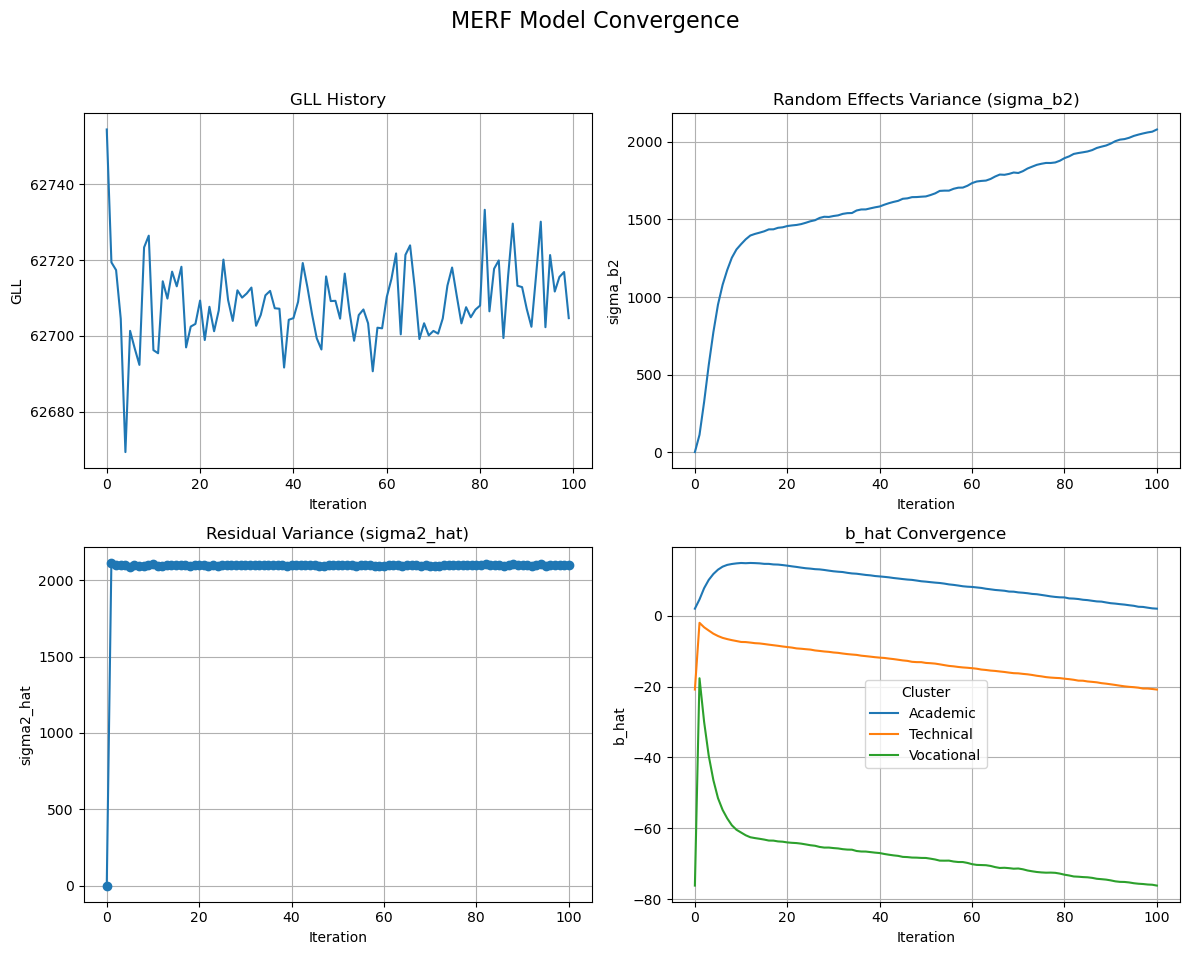

In [22]:
plot_merf_convergence(merf, b_hat_hist)

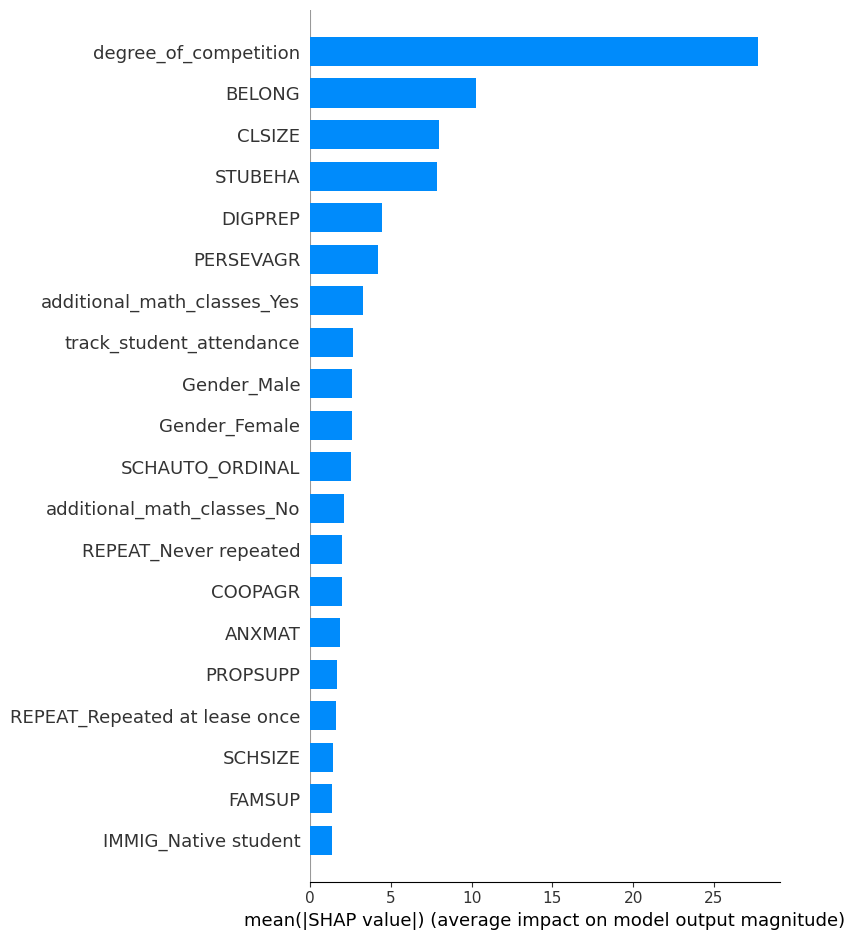

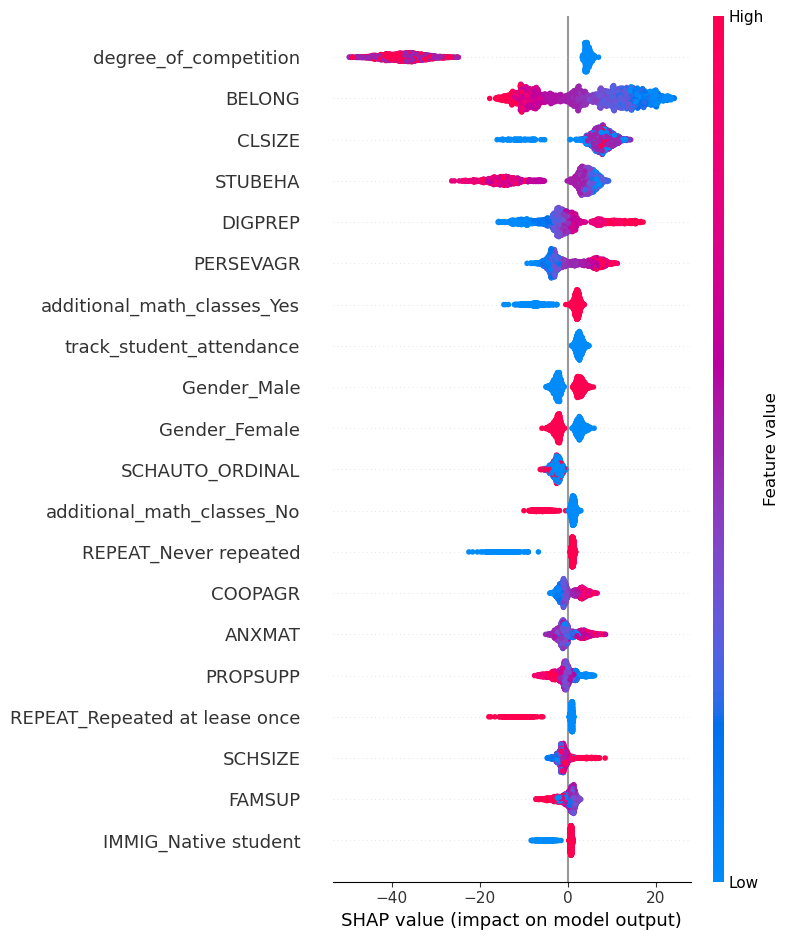

In [26]:
explainer = shap.TreeExplainer(merf.trained_fe_model)
shap_values = explainer.shap_values(X_test_prep_merf)
shap.summary_plot(shap_values, X_test_prep_merf, plot_type="bar")
shap.summary_plot(shap_values, X_test_prep_merf)

In [23]:
# Random Forest
rf.fit(X_train_prep_rf, y_train)
y_pred_rf = rf.predict(X_test_prep_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

In [24]:
print(f"Root Mean Squared Error RF: {rmse_rf:.4f}")
print(f"Mean Absolute Error RF: {mae_rf:.4f}")
print(f"R^2 Score RF: {r2_rf:.4f}")

Root Mean Squared Error RF: 76.5293
Mean Absolute Error RF: 61.0542
R^2 Score RF: 0.2365


In [14]:
# permutation feature importance

imp = permutation_importance(rf, X_test_prep_rf, y=y_test, n_repeats=50)

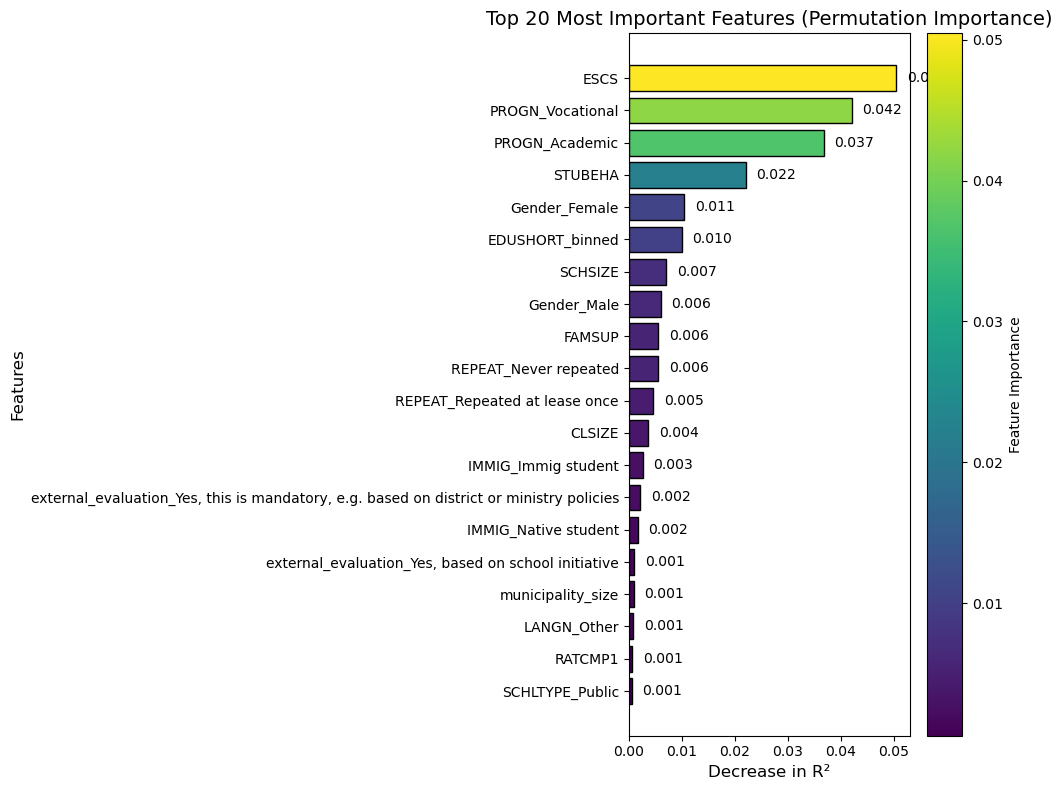

In [ ]:

# Compute the mean importances for each feature
df_importances_mean = df_importances.mean(axis=0)

# Sort by importance and take the top 20 features
top_20 = df_importances_mean.sort_values(ascending=False).head(20)

# Create a normalized colormap for color grading
norm = plt.Normalize(top_20.min(), top_20.max())
colors = cm.viridis(norm(top_20.values))  # You can use 'viridis', 'plasma', or other colormaps

# Create the plot
plt.figure(figsize=(10, 8))
bars = plt.barh(top_20.index, top_20.values, color=colors, edgecolor="black")

# Add text labels for the feature importances
for bar, importance in zip(bars, top_20.values):
    plt.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height() / 2,
             f'{importance:.3f}', va='center', ha='left', fontsize=10)

# Customize the appearance
plt.gca().invert_yaxis()  # Ensure the highest importance feature is on top
plt.title("Top 20 Most Important Features (Permutation Importance)", fontsize=14)
plt.xlabel("Decrease in R²", fontsize=12)
plt.ylabel("Features", fontsize=12)

# Add a color bar
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
plt.colorbar(sm, label="Feature Importance")

plt.tight_layout()
plt.show()


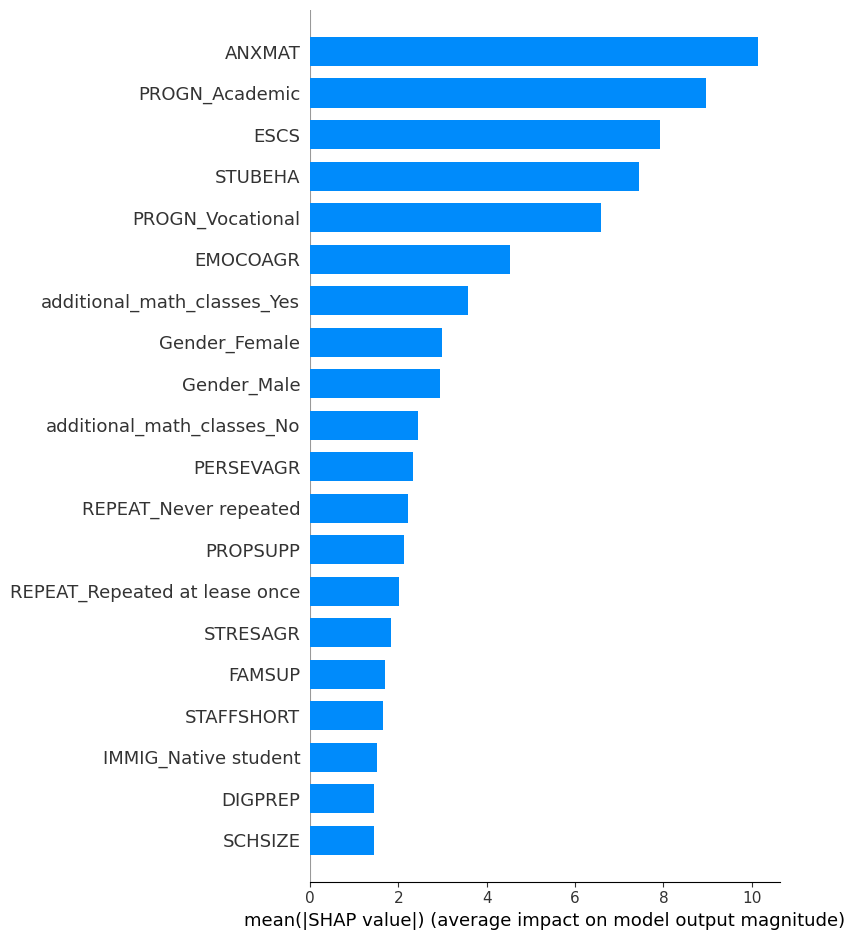

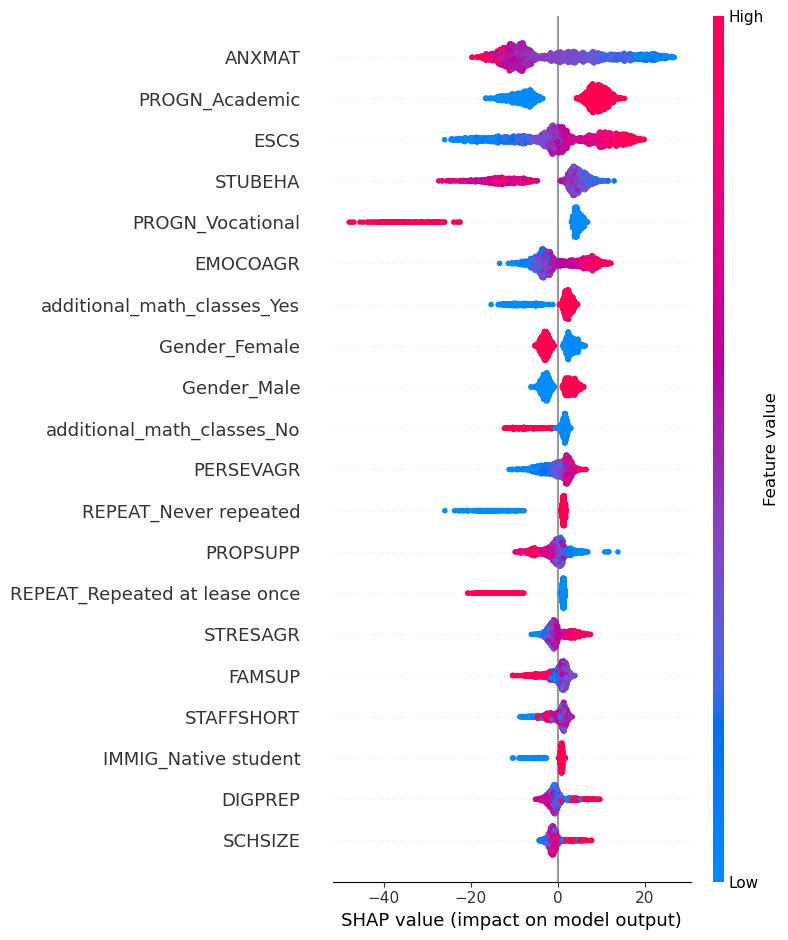

In [27]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_prep_rf)
shap.summary_plot(shap_values, X_test_prep_rf, plot_type="bar")
shap.summary_plot(shap_values, X_test_prep_rf)

In [25]:
lasso = Lasso(alpha=0.8724190503403983, random_state=42)  # best model lasso

lasso.fit(X_train_prep_lasso, y_train)
y_pred_lasso = lasso.predict(X_test_prep_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Root Mean Squared Error lasso: {rmse_lasso:.4f}")
print(f"Mean Absolute Error lasso: {mae_lasso:.4f}")
print(f"R^2 Score lasso: {r2_lasso:.4f}")

Root Mean Squared Error lasso: 75.8334
Mean Absolute Error lasso: 60.4554
R^2 Score lasso: 0.2503


In [28]:
# Extract coefficients and feature names
coefficients = lasso.coef_
feature_names = X_train_prep_lasso.columns  
coefficients_df = pd.DataFrame(coefficients, index=feature_names, columns=["Coefficient"])
coefficients_str = coefficients_df.astype(str)
non_zero_coef_df = coefficients_df.loc[~coefficients_str["Coefficient"].str.strip().str.match(r'^-?0(\.0+)?$')]
non_zero_coef_df

,Coefficient
FAMSUP,-1.098397
STUBEHA,-6.537107
STAFFSHORT,0.017736
PROPSUPP,-2.980437
SCHSIZE,0.772596
RATCMP1,0.742167
BULLIED,-1.993276
REPEAT_Repeated at lease once,-26.768077
IMMIG_Native student,5.806051
external_evaluation_No,-1.247329


In [33]:
# saving rf and merf with psychological variables:
with open('rf_expanded.pkl', 'wb') as file:
    pickle.dump(rf, file)
with open('merf_expanded.pkl', 'wb') as file:
    pickle.dump(merf, file)

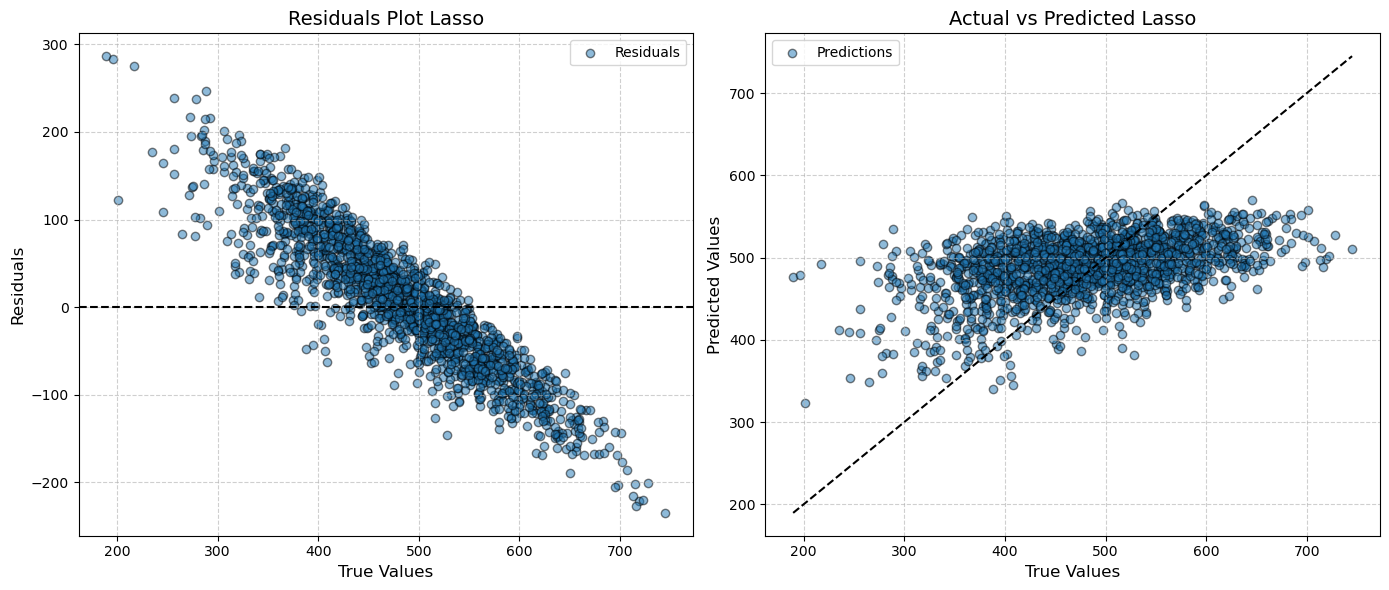

In [9]:
plot_model_diagnostics(y_test, y_pred_lasso, model_name="Lasso")

In [29]:
def plot_kde(y_true, y_pred, model_name):
    # Calculate standard deviations
    std_y_true = np.std(y_true)
    std_y_pred = np.std(y_pred)
    
    plt.figure(figsize=(10, 6))
     
    # Plot KDE for True and Predicted Values
    sns.kdeplot(y_true, color= "#006400" , fill=True, alpha=0.5, label=f"True Values (Std: {std_y_true:.2f})", linewidth=2)
    sns.kdeplot(y_pred, color="#8B0000" , fill=True, alpha=0.5, label=f"Predicted Values (Std: {std_y_pred:.2f})", linewidth=2)

    plt.title(f'True vs Predicted Distributions - {model_name}', fontsize=16)
    plt.xlabel("Values", fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.legend(fontsize=12)

    # Adjust grid for only vertical lines
    plt.grid(axis='x', linestyle="--", alpha=0.6)  # Enable grid only for x-axis (vertical lines)
    plt.gca().yaxis.grid(False)  # Disable horizontal lines
    sns.despine(trim=True)
    plt.tight_layout()
    plt.show()

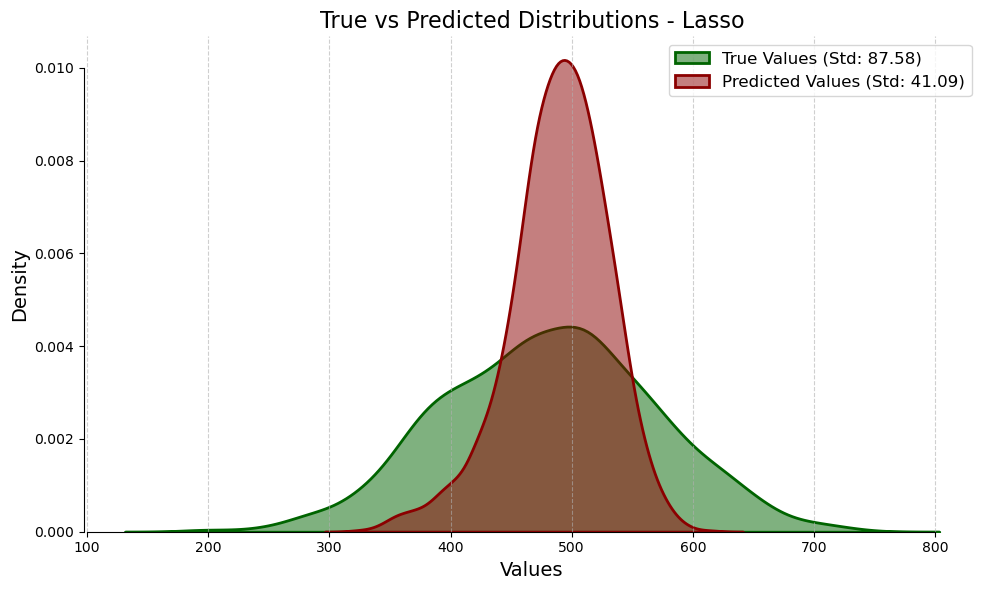

In [30]:
plot_kde(y_test, y_pred_lasso, 'Lasso')

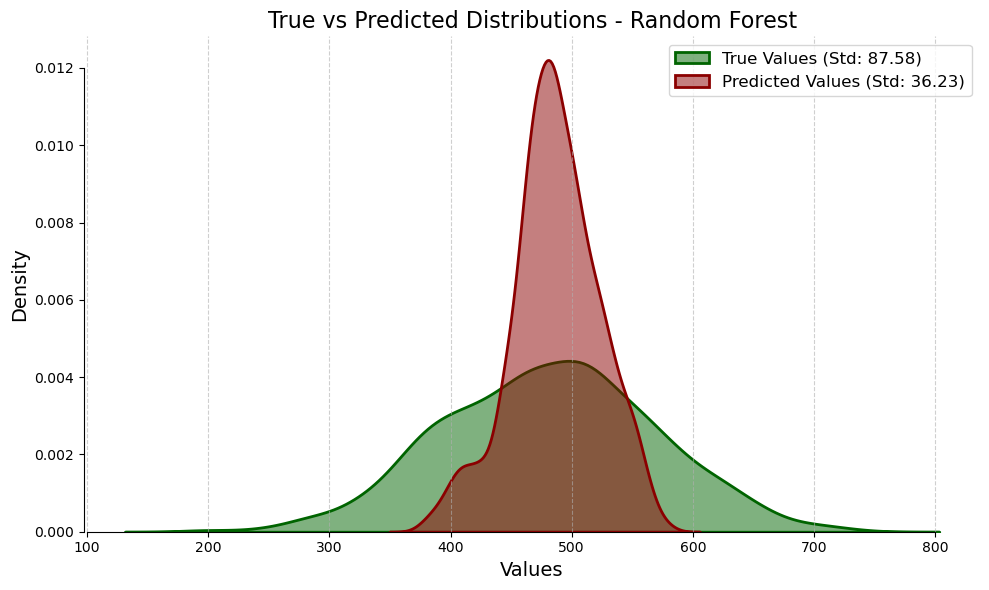

In [31]:
plot_kde(y_test, y_pred_rf, 'Random Forest')

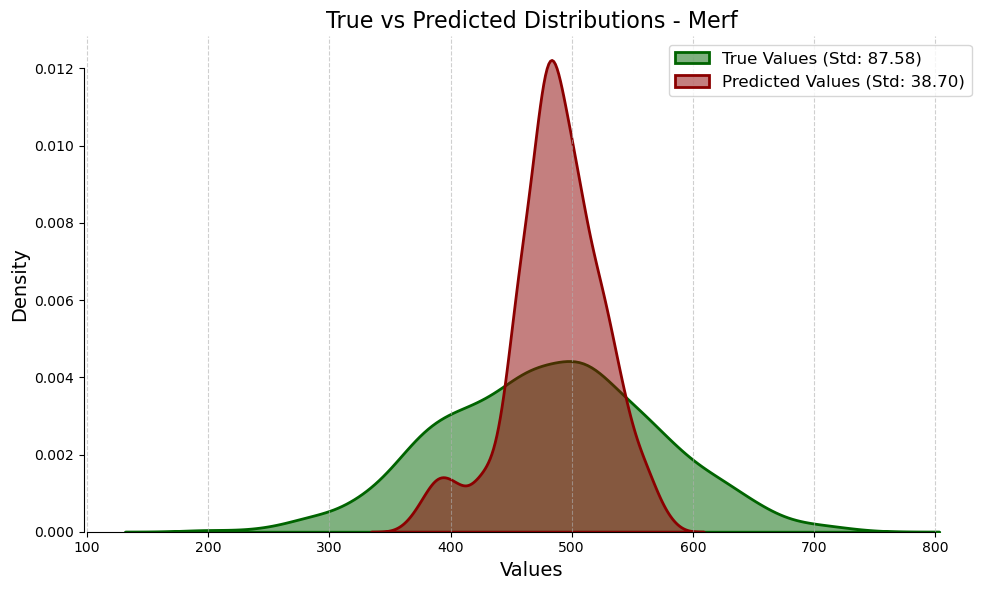

In [32]:
plot_kde(y_test, y_pred_merf, 'Merf')

In [28]:
rmse_merf, mae_merf, r2_merf = 78.61088133489525, 63.00591273955935, 0.19436363750193808
metrics_dict = {
    "Random Forest": [rmse_rf, mae_rf, r2_rf],
    "Lasso": [rmse_lasso, mae_lasso, r2_lasso],
    "MERF": [rmse_merf, mae_merf, r2_merf],
}

metrics_df = pd.DataFrame.from_dict(
    metrics_dict,
    orient="index",
    columns=["RMSE", "MAE", "R²"]
)
metrics_df

,RMSE,MAE,R²
Random Forest,79.301833,63.572114,0.180139
Lasso,78.367449,62.445161,0.199346
MERF,78.610881,63.005913,0.194364
